In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np


def load_omega_time_ga_run(run_dir: str | Path) -> Dict[str, Any]:
    """
    Load ALL gen_*/meta.json files in a GA run directory (e.g. OmegaTimeGA_20260204_154626),
    including omega_vector and time_vector.

    Returns dict with:
      - run_dir: str
      - records: list[dict] (sorted by gen)
      - scalar: dict[str, np.ndarray]  (per-gen scalars)
      - omega_matrix: np.ndarray (G, M) or None
      - time_matrix:  np.ndarray (G, M) or None
      - detuning_matrix:  np.ndarray (G, M) or None
      - unique_pairs: list[list[int]] or None  (from first meta that has it)
      - meta_paths: list[str]
      - missing_meta: list[str]
      - errors: list[tuple[str, str]]
    """
    run_dir = Path(run_dir)
    if not run_dir.is_dir():
        raise FileNotFoundError(f"Run directory not found: {run_dir}")

    gen_dirs = sorted([p for p in run_dir.iterdir() if p.is_dir() and p.name.startswith("gen_")])

    records: List[Dict[str, Any]] = []
    meta_paths: List[str] = []
    missing_meta: List[str] = []
    errors: List[Tuple[str, str]] = []

    for gd in gen_dirs:
        meta_path = gd / "meta.json"
        if not meta_path.exists():
            missing_meta.append(str(meta_path))
            continue

        try:
            with meta_path.open("r") as f:
                meta = json.load(f)

            # Fill gen from folder name if absent
            if "gen" not in meta:
                try:
                    meta["gen"] = int(gd.name.split("_", 1)[1])
                except Exception:
                    meta["gen"] = None

            meta["_meta_path"] = str(meta_path)
            records.append(meta)
            meta_paths.append(str(meta_path))
        except Exception as e:
            errors.append((str(meta_path), repr(e)))

    # Sort records by gen (fall back to path if needed)
    records.sort(key=lambda d: (d.get("gen") is None, d.get("gen", 10**9), d.get("_meta_path", "")))

    # Pull unique_pairs from first record that has it
    unique_pairs = None
    for r in records:
        if "unique_pairs" in r and r["unique_pairs"] is not None:
            unique_pairs = r["unique_pairs"]
            break

    # Helper: scalar columns
    def _scalar_col(key: str) -> np.ndarray:
        vals = []
        for r in records:
            v = r.get(key, None)
            vals.append(np.nan if v is None else v)
        try:
            return np.asarray(vals, dtype=float)
        except Exception:
            # If mixed types, coerce to object then to float where possible
            out = np.full(len(vals), np.nan, dtype=float)
            for i, v in enumerate(vals):
                try:
                    out[i] = float(v)
                except Exception:
                    pass
            return out

    scalar = {
        "gen": _scalar_col("gen"),
        "score": _scalar_col("score"),
        "score_SLM": _scalar_col("score_SLM"),
        "score_AOD": _scalar_col("score_AOD"),
        "nzbar_SLM": _scalar_col("nzbar_SLM"),
        "nzbar_AOD": _scalar_col("nzbar_AOD"),
        "survive_SLM": _scalar_col("survive_SLM"),
        "survive_AOD": _scalar_col("survive_AOD"),
        "num_pulses": _scalar_col("num_pulses"),
    }

    # Build omega/time matrices (G, M) if present and consistent
    omega_lists = [r.get("omega_vector", None) for r in records]
    time_lists  = [r.get("time_vector", None) for r in records]
    detuning_lists  = [r.get("detuning_offsets", None) for r in records]

    def _stack_vectors(vec_lists: List[Any], name: str) -> np.ndarray | None:
        # Find first non-empty vector to determine M
        M = None
        for v in vec_lists:
            if isinstance(v, list) and len(v) > 0:
                M = len(v)
                break
        if M is None:
            return None

        mat = np.full((len(vec_lists), M), np.nan, dtype=float)
        for i, v in enumerate(vec_lists):
            if isinstance(v, list) and len(v) == M:
                mat[i, :] = np.asarray(v, dtype=float)
            elif v is None:
                continue
            else:
                # length mismatch -> leave NaNs
                # (you can raise instead if you prefer strictness)
                continue
        return mat

    omega_matrix = _stack_vectors(omega_lists, "omega_vector")
    time_matrix  = _stack_vectors(time_lists, "time_vector")
    detuning_matrix  = _stack_vectors(detuning_lists, "detuning_offsets")

    return {
        "run_dir": str(run_dir),
        "records": records,
        "scalar": scalar,
        "omega_matrix": omega_matrix,
        "time_matrix": time_matrix,
        "detuning_matrix": detuning_matrix,
        "unique_pairs": unique_pairs,
        "meta_paths": meta_paths,
        "missing_meta": missing_meta,
        "errors": errors,
    }


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_ga_metrics(run_data, *, fontsize=14, score_scale=1.0/10_000):
    """
    Plot score, nbar_z, and survival vs generation.

    Parameters
    ----------
    run_data : dict
        Output of load_omega_time_ga_run(...)
    fontsize : int
        Font + tick size
    score_scale : float
        Multiply score by this factor before plotting (e.g. 1.0 = raw score).
    """
    gen = run_data["scalar"]["gen"]
    score = run_data["scalar"]["score"] * score_scale
    score_SLM = run_data["scalar"]["score_SLM"] * score_scale
    score_AOD = run_data["scalar"]["score_AOD"] * score_scale
    n_bar_SLM = run_data["scalar"]["nzbar_SLM"]
    n_bar_AOD = run_data["scalar"]["nzbar_AOD"]
    survive_SLM = run_data["scalar"]["survive_SLM"]
    survive_AOD = run_data["scalar"]["survive_AOD"]

    mask = ~np.isnan(gen)
    gen = gen[mask].astype(int)
    score = score[mask]
    score_SLM = score_SLM[mask]
    score_AOD = score_AOD[mask]
    n_bar_SLM = n_bar_SLM[mask]
    n_bar_AOD = n_bar_AOD[mask]
    survive_SLM = survive_SLM[mask]
    survive_AOD = survive_AOD[mask]

    fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

    axes[0].plot(gen, score, "-o", label="Total Score")
    axes[0].plot(gen, score_SLM, "-o", label="SLM Score")
    axes[0].plot(gen, score_AOD, "-o", label="AOD Score")
    axes[0].set_ylabel("Score", fontsize=fontsize)
    axes[0].set_title("GA optimization progress", fontsize=fontsize)
    axes[0].grid(True, alpha=0.4)
    axes[0].legend(fontsize=fontsize)

    axes[1].plot(gen, n_bar_SLM, "-o", label="SLM")
    axes[1].plot(gen, n_bar_AOD, "-o", label="AOD")
    axes[1].set_ylabel(r"$\bar{n}_z$", fontsize=fontsize)
    axes[1].legend(fontsize=fontsize)
    axes[1].grid(True, alpha=0.4)

    axes[2].plot(gen, survive_SLM, "-o", label="SLM")
    axes[2].plot(gen, survive_AOD, "-o", label="AOD")
    axes[2].set_ylabel("Survival", fontsize=fontsize)
    axes[2].set_xlabel("Generation", fontsize=fontsize)
    axes[2].legend(fontsize=fontsize)
    axes[2].grid(True, alpha=0.4)

    for ax in axes:
        ax.tick_params(axis="both", labelsize=fontsize)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_omega_time_vs_generation_by_axis(
    run_data,
    *,
    fontsize=14,
    plot_axis={"x", "y", "z"},
):
    """
    3 rows × N columns (N = number of selected axes):
      Row 0: Omega vs gen (kHz)
      Row 1: Time  vs gen (µs)
      Row 2: Detuning vs gen (kHz) (if available)
    Columns correspond to selected axes in plot_axis.
    """

    # Normalize axis selection
    axis_map = {"x": 0, "y": 1, "z": 2}
    plot_axis = {a.lower() for a in plot_axis}

    invalid = plot_axis - set(axis_map.keys())
    if invalid:
        raise ValueError(f"Invalid axis in plot_axis: {invalid}")

    # Keep columns in X,Y,Z order (filtered)
    axis_order = ["x", "y", "z"]
    selected_axes = [axis_map[a] for a in axis_order if a in plot_axis]
    n_cols = len(selected_axes)
    if n_cols == 0:
        raise ValueError("plot_axis must contain at least one of {'x','y','z'}")

    gen = run_data["scalar"]["gen"]
    omega_mat = run_data["omega_matrix"]        # (G, M), Hz
    time_mat  = run_data["time_matrix"]         # (G, M), s
    detuning_mat = run_data.get("detuning_matrix", None)  # (G, M), Hz or None
    unique_pairs = run_data["unique_pairs"]

    if omega_mat is None or time_mat is None or unique_pairs is None:
        raise ValueError("run_data must contain omega_matrix, time_matrix, and unique_pairs")

    # Mask out NaN generations
    mask = ~np.isnan(gen)
    gen = gen[mask].astype(int)

    omega_mat = omega_mat[mask] * 1e-3   # Hz → kHz
    time_mat  = time_mat[mask] * 1e6     # s  → µs
    if detuning_mat is not None:
        detuning_mat = detuning_mat[mask] * 1e-3  # Hz → kHz

    G, M = omega_mat.shape
    if len(unique_pairs) != M:
        raise ValueError("unique_pairs length does not match omega/time vectors")

    # Group indices by axis
    axis_to_idx = {0: [], 1: [], 2: []}
    for j, (axis, dn) in enumerate(unique_pairs):
        axis_to_idx[int(axis)].append(j)

    axis_names = {0: "X", 1: "Y", 2: "Z"}

    # Auto figure size
    col_w = 6.5   # inches per axis column
    row_h = 4.5   # inches per metric row
    fig_w = max(10.0, col_w * n_cols)
    fig_h = row_h * 3

    fig, axes = plt.subplots(3, n_cols, figsize=(fig_w, fig_h), sharex=True)

    # Handle single-column case (matplotlib returns 1D axes)
    if n_cols == 1:
        axes = axes.reshape(3, 1)

    for col, axis in enumerate(selected_axes):
        idxs = axis_to_idx[axis]

        # --- Row 0: Omega ---
        ax_om = axes[0, col]
        for j in idxs:
            _, dn = unique_pairs[j]
            ax_om.plot(gen, omega_mat[:, j], marker="o", label=f"Δn={dn}")
        ax_om.set_title(f"Ω vs Gen ({axis_names[axis]})", fontsize=fontsize)
        ax_om.set_ylabel("Ω (kHz)", fontsize=fontsize)
        ax_om.grid(True, alpha=0.4)
        ax_om.legend(fontsize=9)

        # --- Row 1: Time ---
        ax_t = axes[1, col]
        for j in idxs:
            _, dn = unique_pairs[j]
            ax_t.plot(gen, time_mat[:, j], marker="o", label=f"Δn={dn}")
        ax_t.set_title(f"t vs Gen ({axis_names[axis]})", fontsize=fontsize)
        ax_t.set_ylabel("t (µs)", fontsize=fontsize)
        ax_t.grid(True, alpha=0.4)
        ax_t.legend(fontsize=9)

        # --- Row 2: Detuning ---
        ax_d = axes[2, col]
        if detuning_mat is not None:
            for j in idxs:
                _, dn = unique_pairs[j]
                ax_d.plot(gen, detuning_mat[:, j], marker="o", label=f"Δn={dn}")
            ax_d.set_ylabel("Detuning (kHz)", fontsize=fontsize)
            ax_d.legend(fontsize=9)
        else:
            ax_d.text(
                0.5, 0.5, "No detuning data",
                ha="center", va="center",
                transform=ax_d.transAxes,
                fontsize=fontsize,
            )
            ax_d.set_ylabel("Detuning", fontsize=fontsize)

        ax_d.set_title(f"Detuning vs Gen ({axis_names[axis]})", fontsize=fontsize)
        ax_d.grid(True, alpha=0.4)
        ax_d.set_xlabel("Generation", fontsize=fontsize)

    for ax in axes.ravel():
        ax.tick_params(axis="both", labelsize=fontsize)

    plt.tight_layout()
    plt.show()


In [5]:
# run = load_omega_time_ga_run("OmegaTimeGA_20260218_100541")
run = load_omega_time_ga_run("OmegaTimeGA_20260219_005734")

print("Loaded records:", len(run["records"]))
print("Omega matrix shape:", None if run["omega_matrix"] is None else run["omega_matrix"].shape)
print("Time  matrix shape:", None if run["time_matrix"]  is None else run["time_matrix"].shape)

# Best generation by score (higher is better in your saved metas since score is negative penalty)
best_i = int(np.nanargmax(run["scalar"]["score"]))
best_gen = int(run["scalar"]["gen"][best_i])
print("Best gen:", best_gen, "score:", run["scalar"]["score"][best_i])

# Omega/time vectors for that best gen:
omega_best = run["omega_matrix"][best_i]
time_best  = run["time_matrix"][best_i]

Loaded records: 40
Omega matrix shape: (40, 16)
Time  matrix shape: (40, 16)
Best gen: 36 score: 3799.278089321707


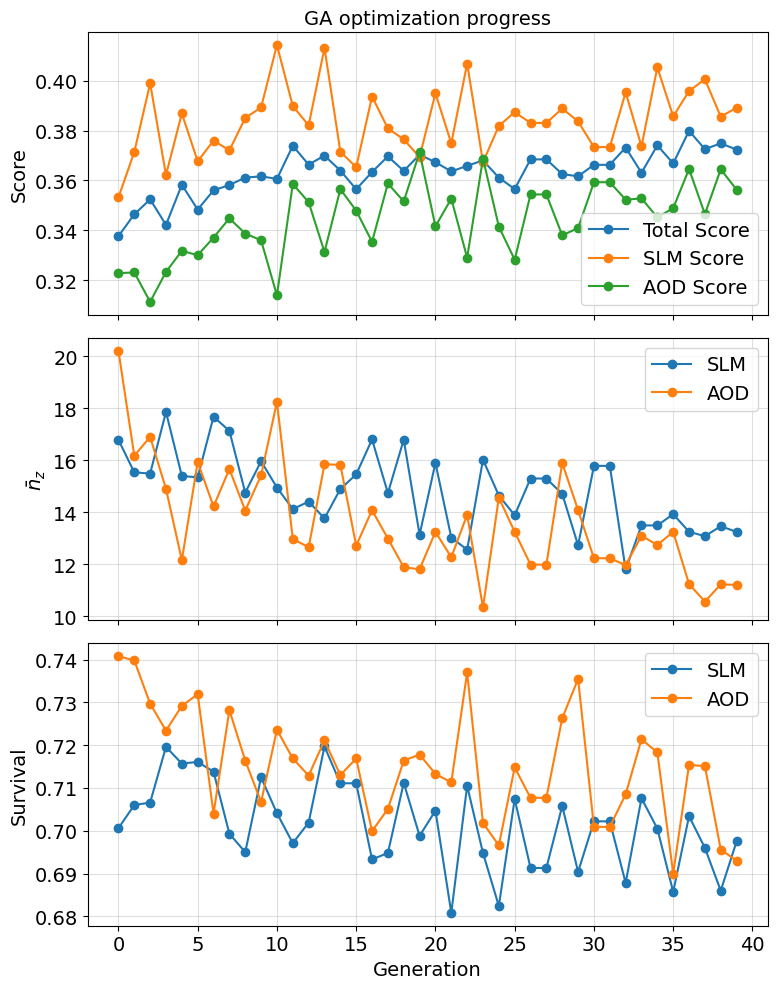

In [6]:
plot_ga_metrics(run)

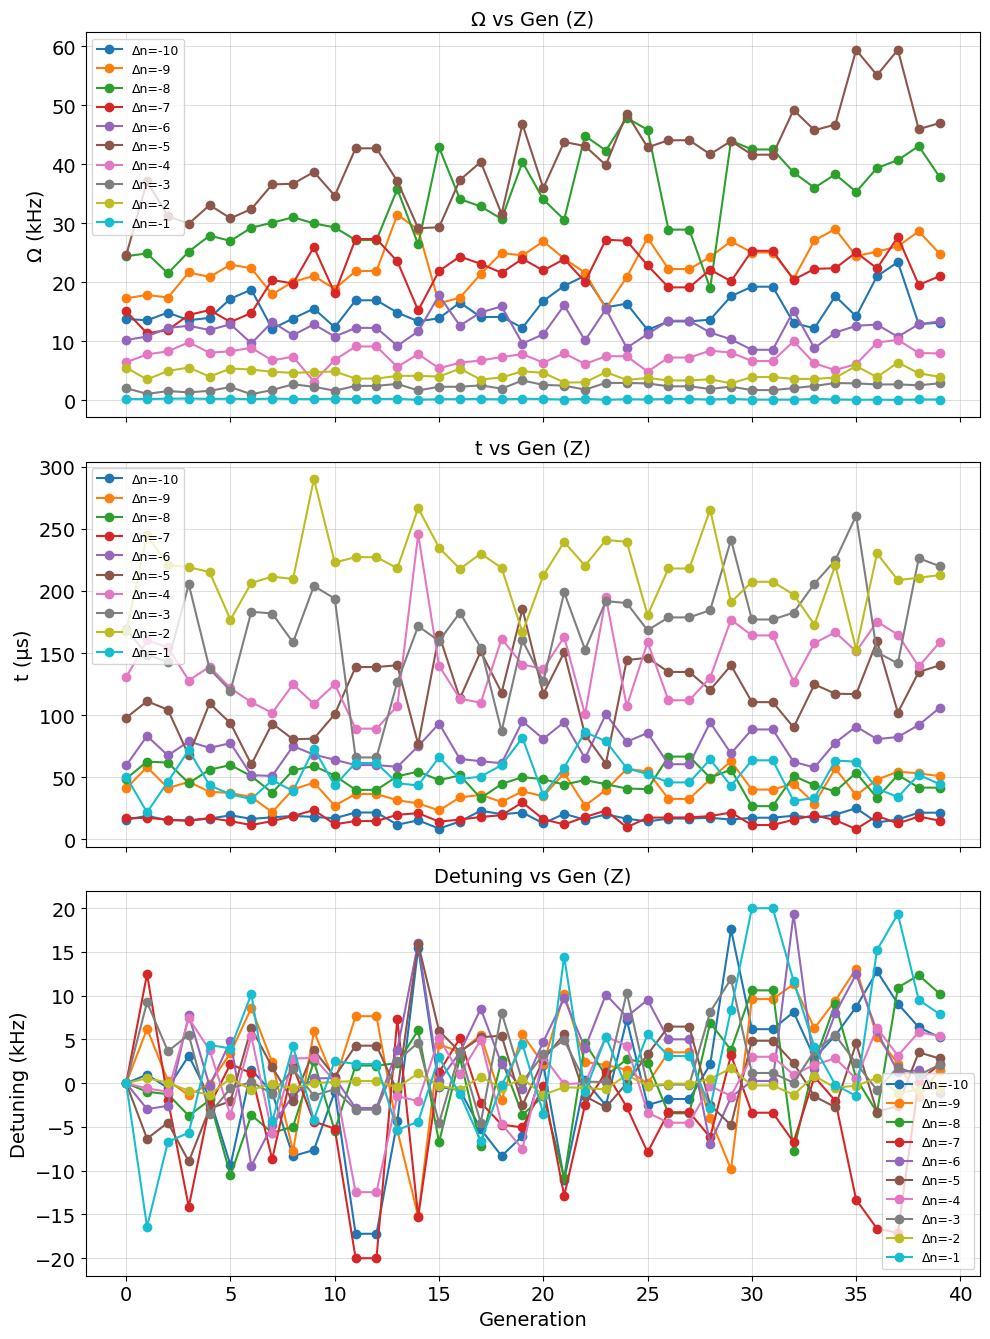

In [7]:
plot_omega_time_vs_generation_by_axis(run, plot_axis={"z"})